In [312]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define Classes

In [313]:
class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "Add",
    "Decimal",
    "Division",
    "Equals",
    "Multiply",
    "Minus",
    "X",
    "Y",
    "Z",
]

# Load Model

In [314]:

model = tf.keras.models.load_model("models/19_class.h5")

# Helper Function

In [315]:
def show_img(img):
    plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)
    
    
def show_images(images, title=''):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(4,4,i+1)
        plt.imshow(image)
        plt.title(title)
    
    
def show_prediction(image):
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')/255

    predictions = model.predict(image)
    label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)*100
    confidence = str(confidence)[:2]
    
    return label,confidence

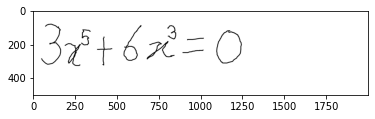

In [316]:
img_path = 'test_cases/poly.png'
image = cv.imread(img_path)
show_img(image)

# Do some preprocessing

In [317]:
gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
edged = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 11, 4)
(contours, _) = cv.findContours(edged, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

# Find Bounding box using Contours 

In [318]:
chars_bb = []
for contour in contours:
            contour = contour.reshape((contour.shape[0],contour.shape[2]))
            left_tc = np.amin(contour, axis=0)
            right_bc = np.amax(contour, axis=0)
            min_x = left_tc[0]
            max_x = right_bc[0]
            min_y = left_tc[1]
            max_y = right_bc[1]
            chars_bb.append([min_x,min_y,max_x,max_y])

# Show bounding box

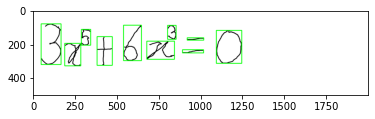

In [319]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),3)
    #print(box)
    
show_img(copy)

# Replacing Double Minus as EqualsTo

Note even though this logic should repalce most double minus with
equals to we still need further logic to explicitly convert two 
consecutive minus as equals

In [320]:
def remove_equals(chars_bb):    
    chars_bb.sort()
    for i, box in enumerate(chars_bb):
        try:
            next_box = chars_bb[i+1]
        except IndexError:
            break
    
        if abs(box[0] - next_box[0]) <= 30:
            min_x = min(box[0],next_box[0])
            min_y = min(box[1],next_box[1])
            max_x = max(box[2],next_box[2])
            max_y = max(box[3],next_box[3])
            new_box = [min_x,min_y,max_x,max_y]
            chars_bb[i] = new_box
            chars_bb.remove(next_box)
    return chars_bb 
        
chars_bb = remove_equals(chars_bb)        

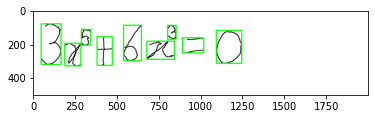

In [321]:
copy = image.copy()
for box in chars_bb:
    cv.rectangle(copy, (box[0], box[1]), (box[2],box[3]),(0,255,0),5)
    
show_img(copy)

# Calssify if image is superscript or not

In [322]:
def get_centroid(chars_bb):
   centroids = []
   for _, box in enumerate(chars_bb):
      centroidX, centroidY = (int((box[0]+box[2])/2),int((box[1]+box[3])/2))
      centroids.append((centroidX,centroidY))
   return centroids

In [323]:
def classify_superscript(centroids, chars_bb):
    is_super = ['base' for _ in range(len(chars_bb))]
    for i, box in enumerate(chars_bb):
        try:
            next_box = chars_bb[i+1]
        except IndexError:
            is_super.append('base')
            return is_super
        
        bb1_y1 = box[1]
        bb2_y2 = next_box[3]
        cb1y = centroids[i][1]
        cb2y = centroids[i+1][1]
       
     
        if bb1_y1 > cb2y and cb1y > bb2_y2:
            is_super[i+1] = 'super'


            
    

# Crop the Images

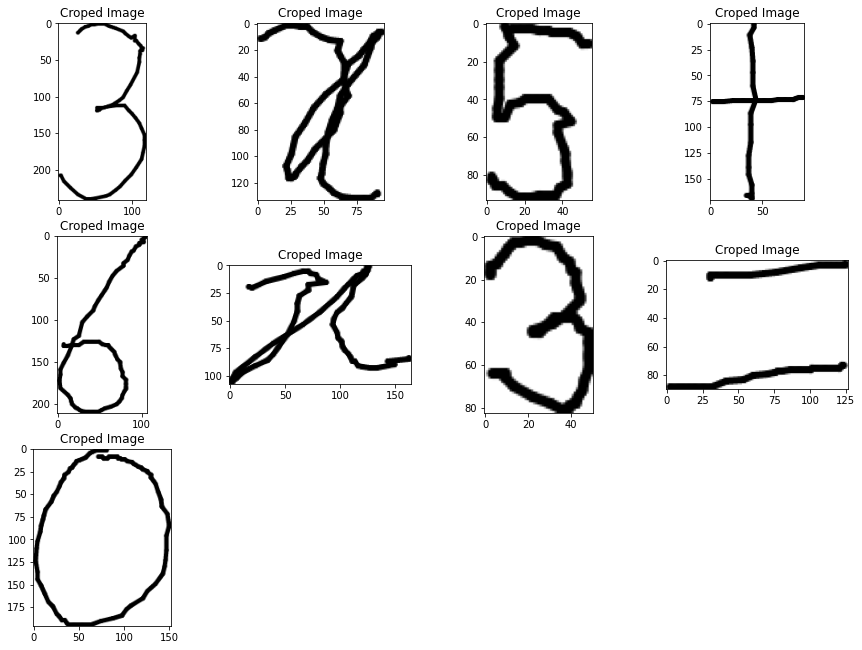

In [324]:
def get_cropped_images(image,chars_bb):
    croped_images = []
    copy = image.copy()
    for box in chars_bb:
        x_min = box[0]
        y_min = box[1]
        height = abs(box[0]-box[2])
        width = abs(box[1]-box[3])
        character = copy[y_min:y_min+width , x_min:x_min+height]
        croped_images.append(character)
    return croped_images    
    
croped_images = get_cropped_images(image,chars_bb)
show_images(croped_images, title='Croped Image')

In [325]:
def extra_padding(img, padding=50):
    return cv.copyMakeBorder(img, top=padding, bottom=padding, left=padding, right=padding, borderType=cv.BORDER_CONSTANT, value=(255,255,255))

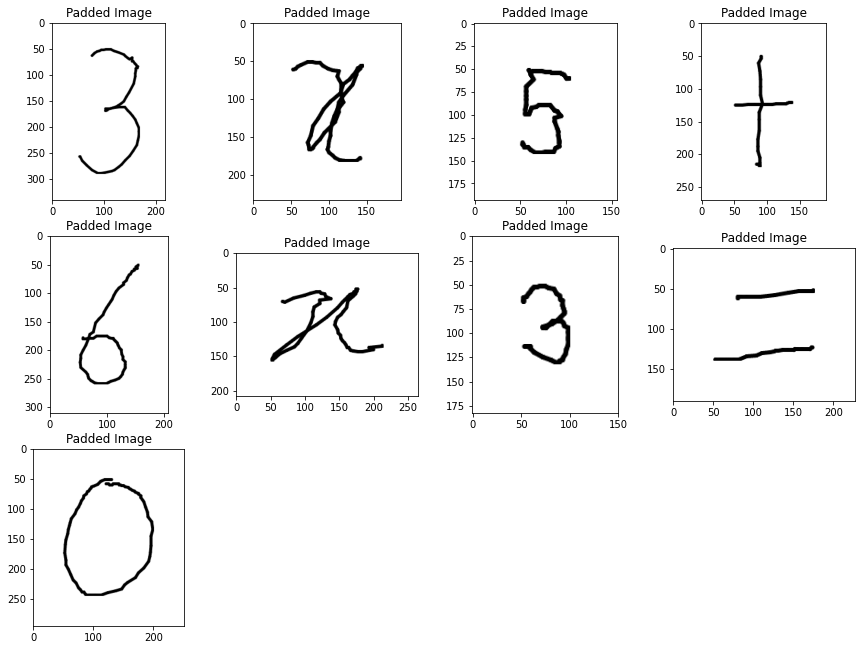

In [326]:
padded_images = []
for img in croped_images:
    padded_img = extra_padding(img)
    padded_images.append(padded_img)

show_images(padded_images, title='Padded Image')

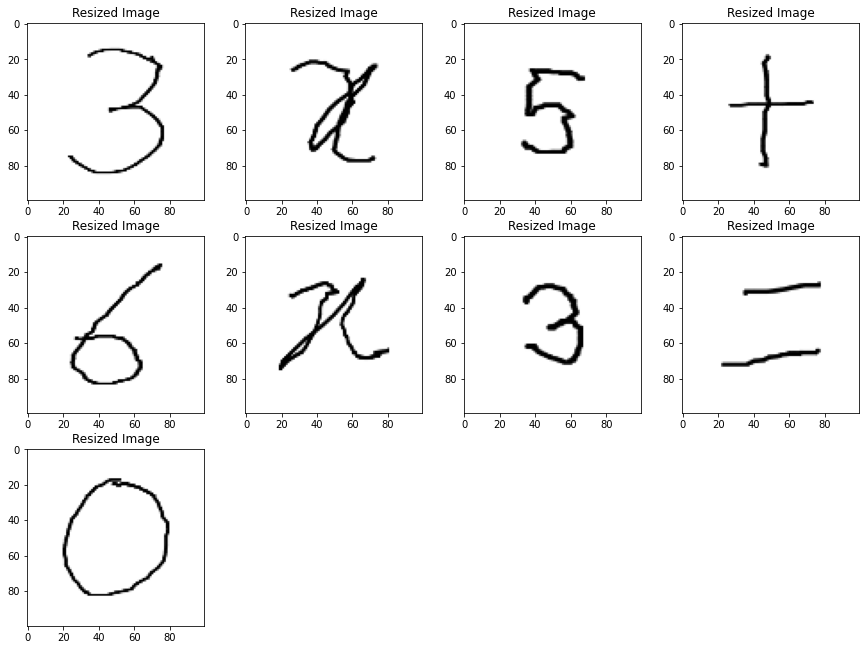

In [327]:
resized_images = []
for img in padded_images:
    resized_img = cv.resize(img, (100, 100), interpolation=cv.INTER_LINEAR)
    resized_images.append(resized_img)

show_images(resized_images, title='Resized Image')

['base', 'base', 'super', 'base', 'base', 'base', 'super', 'base', 'base', 'base']


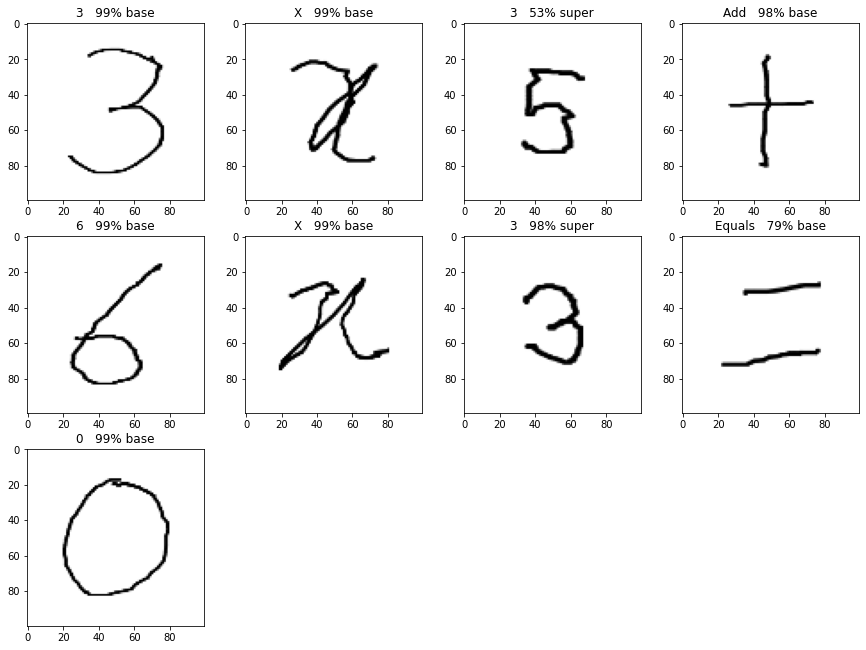

In [328]:
centroids = get_centroid(chars_bb)
is_super = classify_superscript(centroids,chars_bb)
print(is_super)
plt.figure(figsize=(15, 15))
for i, img in enumerate(resized_images):
    label, conf = show_prediction(img)
    plt.subplot(4,4,i+1)
    plt.imshow(img)
    title = label+'   '+ conf + '% ' + is_super[i]
    plt.title(title)
   